### 最初方案的脚本，可以找到椭圆的长短径

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def threshold_binary(image_path, threshold):
    # 读取图像
    image = cv2.imread(image_path, 0)  # 以灰度模式读取图像

    # 对图像进行阈值二值化
    _, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)

    return binary_image

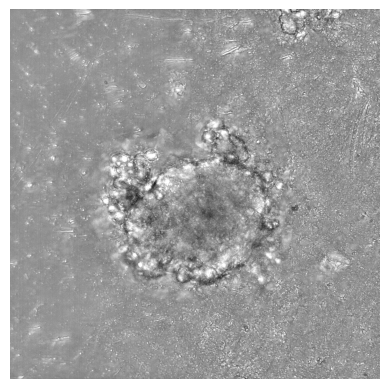

In [3]:
# 首先对图像进行二值化
image_path = 'SINGLE/E7_B.png'  # 替换为实际图像的路径
threshold = 0  # 阈值设定

image = cv2.imread(image_path, 0)

# 使用matplotlib显示图像
plt.imshow(image, cmap='gray')  # cmap参数用于指定灰度图像的颜色映射，默认为'viridis'
plt.axis('off')  # 关闭坐标轴
plt.show()

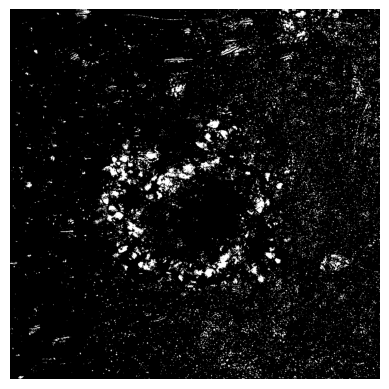

In [8]:
threshold = 200  # 阈值设定
binary_image = threshold_binary(image_path, threshold)

# 使用matplotlib显示图像
plt.imshow(binary_image, cmap='gray')  # cmap参数用于指定灰度图像的颜色映射，默认为'viridis'
plt.axis('off')  # 关闭坐标轴
plt.show()

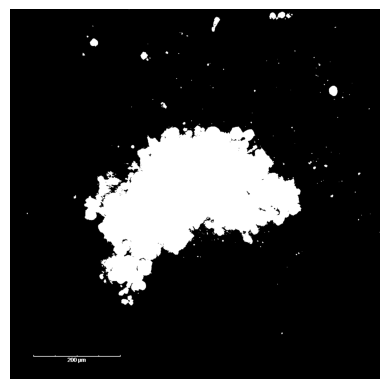

In [6]:
# 示例用法
image_path = '20231103-ZYL-ALL/1030-D0-1-all/B2-G.png'  # 替换为实际图像的路径
threshold = 0  # 阈值设定

binary_image = threshold_binary(image_path, threshold)

# 使用matplotlib显示图像
plt.imshow(binary_image, cmap='gray')  # cmap参数用于指定灰度图像的颜色映射，默认为'viridis'
plt.axis('off')  # 关闭坐标轴
plt.show()

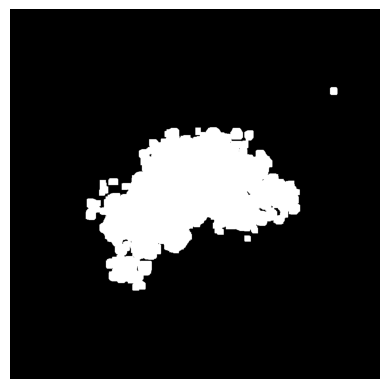

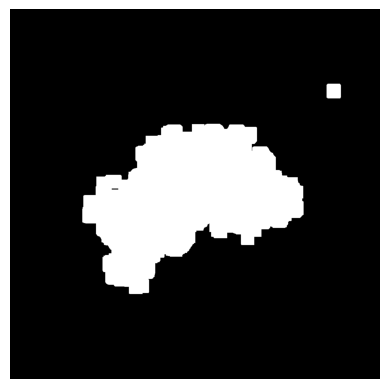

In [8]:
# 对二值化图像进行开运算，以及进行膨胀！！！
kernel = np.ones((16, 16), np.uint8)

# 开运算
opening = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

# 使用matplotlib显示图像
plt.imshow(opening, cmap='gray')  # cmap参数用于指定灰度图像的颜色映射，默认为'viridis'
plt.axis('off')  # 关闭坐标轴
plt.show()

# 定义膨胀核
kernel = np.ones((5, 5), np.uint8)

# 进行膨胀处理
dilated_img = cv2.dilate(opening, kernel, iterations=5)

# 使用matplotlib显示图像
plt.imshow(dilated_img, cmap='gray')  # cmap参数用于指定灰度图像的颜色映射，默认为'viridis'
plt.axis('off')  # 关闭坐标轴
plt.show()


椭圆中心坐标： 459.7916259765625 294.32537841796875
椭圆长轴和短轴长度： 459.1047058105469 648.056884765625
旋转角度： 163.80227661132812


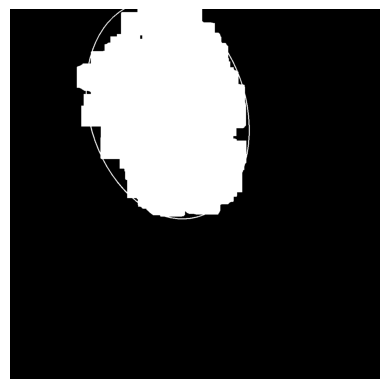

In [188]:
# 寻找轮廓
contours, hierarchy = cv2.findContours(dilated_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 初始化最大椭圆面积和对应的椭圆参数
max_area = 0
max_ellipse = None

# 对每个轮廓进行椭圆拟合
for contour in contours:
    if len(contour) >= 5:  # 至少需要5个点才能拟合椭圆
        ellipse = cv2.fitEllipse(contour)
        # 计算椭圆面积
        area = np.pi * ellipse[1][0] * ellipse[1][1]
        # 如果当前椭圆面积大于最大椭圆面积，则更新最大椭圆参数
        if area > max_area:
            max_area = area
            max_ellipse = ellipse

ellipse = max_ellipse
cv2.ellipse(dilated_img, max_ellipse, (255, 255, 255), 2)  # 在图像上绘制椭圆



# 获取椭圆信息
center_x, center_y = ellipse[0]
axis_major, axis_minor = ellipse[1]
angle = ellipse[2]

print("椭圆中心坐标：", center_x, center_y)
print("椭圆长轴和短轴长度：", axis_major, axis_minor)
print("旋转角度：", angle)

# 使用matplotlib显示图像
plt.imshow(dilated_img, cmap='gray')  # cmap参数用于指定灰度图像的颜色映射，默认为'viridis'
plt.axis('off')  # 关闭坐标轴
plt.show()



In [189]:
# 增加两个小椭圆的参数
ellipse_Ti = (ellipse[0],(ellipse[1][0]/3, ellipse[1][1]/3), ellipse[2])
ellipse_S = (ellipse[0],(ellipse[1][0] * 2 /3, ellipse[1][1] * 2 /3), ellipse[2])


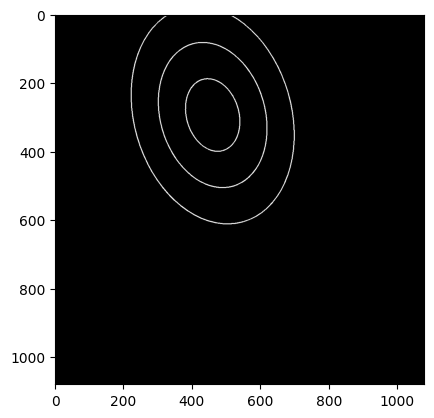

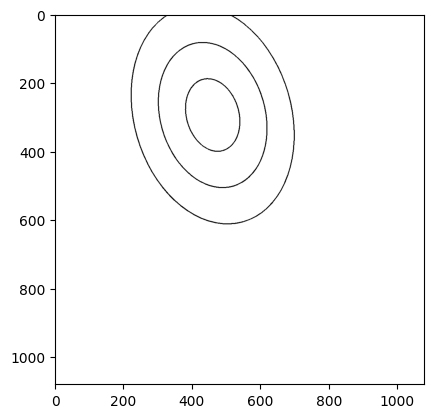

In [190]:


mask = np.zeros((dilated_img.shape))

cv2.ellipse(mask, ellipse, (255, 255, 255), 2)  # 在图像上绘制椭圆
cv2.ellipse(mask, ellipse_S, (255, 255, 255), 2)  # 在图像上绘制椭圆
# 使用matplotlib显示图像
cv2.ellipse(mask, ellipse_Ti, (255, 255, 255), 2)  # 在图像上绘制椭圆
plt.imshow(mask, cmap='gray')  # cmap参数用于指定灰度图像的颜色映射，默认为'viridis'
plt.axis('on')  # 关闭坐标轴
plt.show()

# 反转mask
mask_ = np.zeros((mask.shape), dtype = np.uint8)
mask_[mask==0] = 1
mask_[mask!=0] = 0
plt.imshow(mask_, cmap='gray')  # cmap参数用于指定灰度图像的颜色映射，默认为'viridis'
plt.axis('on')  # 关闭坐标轴
plt.show()


now show label:  2
sum: 73826 122978


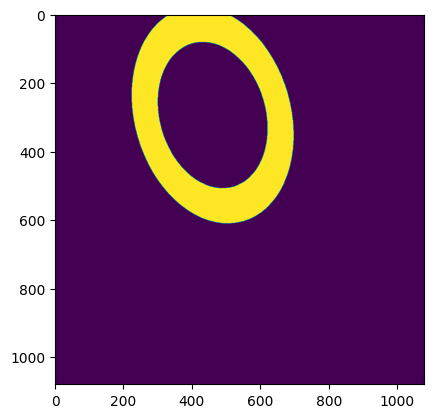

now show label:  3
sum: 46246 75174


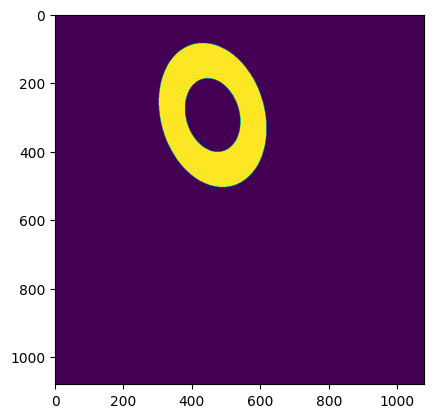

now show label:  4
sum: 25067 25067


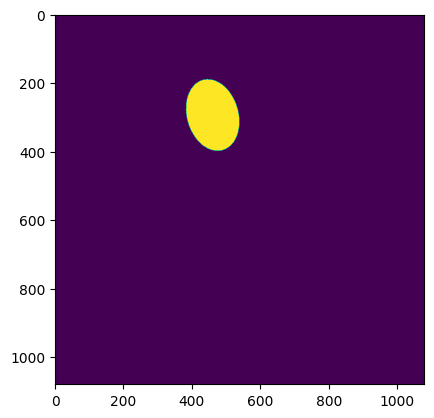

In [191]:
# 取联通区域
num_labels, labels = cv2.connectedComponents(mask_)
output_ellipses = []
# 根据不同的标签，将相应的像素设置为随机颜色
for label in range(2, num_labels):
    mask = labels == label
    print("now show label: ", label)
    output = np.zeros((mask_.shape), dtype=np.uint8)
    output[mask] = 1
    output_ellipses.append(output)
    print('sum:',  sum(sum(output)), np.sum(output))
    plt.imshow(output, cmap='viridis')  # cmap参数用于指定灰度图像的颜色映射，默认为'viridis'
    plt.axis('on')  # 关闭坐标轴
    plt.show()



像素密度： 47.08033144139602


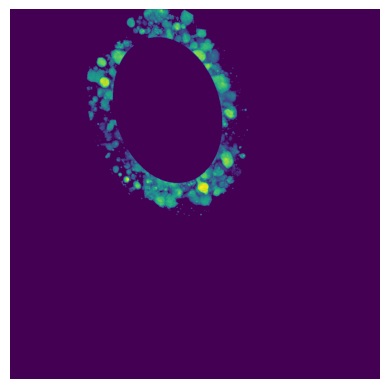

像素密度： 87.2927740974273


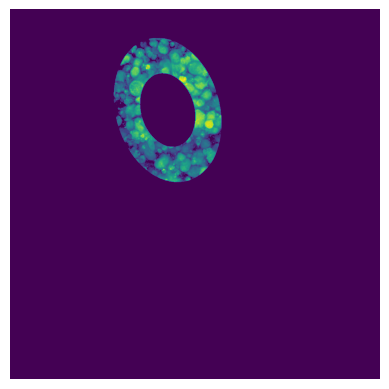

像素密度： 110.94183587984202


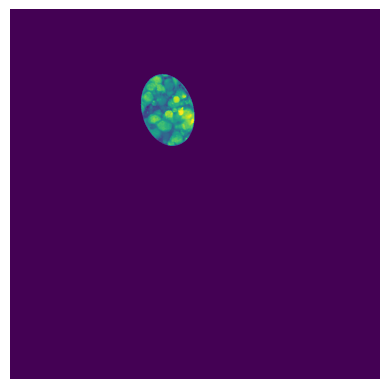

In [194]:
for spatial in output_ellipses:
    # print( np.sum(spatial * image), np.sum(spatial) ) 
    print("像素密度：", np.sum(spatial * image) / np.sum(spatial)) 
    # 使用matplotlib显示图像
    plt.imshow(spatial * image, cmap='viridis')  # cmap参数用于指定灰度图像的颜色映射，默认为'viridis'
    plt.axis('off')  # 关闭坐标轴
    plt.show()
    

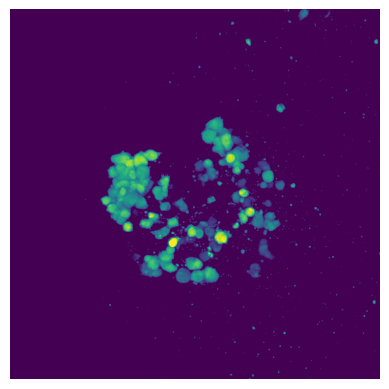

In [160]:
plt.imshow(image, cmap='viridis')  # cmap参数用于指定灰度图像的颜色映射，默认为'viridis'
plt.axis('off')  # 关闭坐标轴
plt.show()

In [166]:
image.min(), image.max()

(0, 202)

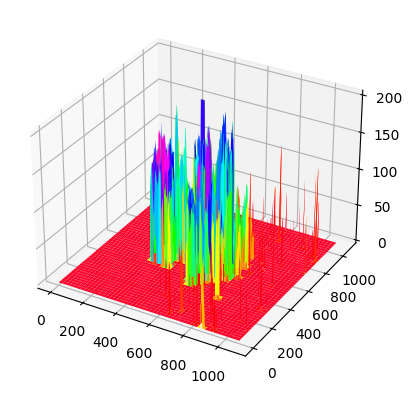

In [162]:
from mpl_toolkits.mplot3d import Axes3D
# img_path = r"./2.jpg"
img_gray = cv2.imread(image_path, 0)

# img_gray = cv2.resize(img_bgr, (224, 224))

Y = np.arange(0, np.shape(img_gray)[0], 1)
X = np.arange(0, np.shape(img_gray)[1], 1)
X, Y = np.meshgrid(X, Y)
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.plot_surface(X, Y, img_gray, cmap='gist_rainbow')  #  cmap='hot'
plt.show()